In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow as pa
!pip install pyarrow


## Leer archivos 

Esta parte es solo para mostrar como se limpiaron y crearon los subconjuntos no es necesario correr esto

In [2]:
df = pd.read_csv("alert_detections_V2.csv")



Normalizamos la data

In [3]:
from sklearn.preprocessing import MinMaxScaler

In [4]:
scaler = MinMaxScaler()

In [5]:
normalized_data = scaler.fit_transform(df[['magpsf_corr']])

In [6]:
df['magpsf_corr'] = normalized_data

In [7]:
normalized_data = scaler.fit_transform(df[['sigmapsf_corr']])

In [8]:
df['sigmapsf_corr'] = normalized_data

In [9]:
normalized_data = scaler.fit_transform(df[['sigmapsf_corr_ext']])

In [10]:
df['sigmapsf_corr_ext'] = normalized_data

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115006366 entries, 0 to 115006365
Data columns (total 7 columns):
 #   Column             Dtype  
---  ------             -----  
 0   oid                object 
 1   candid             int64  
 2   fid                int64  
 3   mjd                float64
 4   magpsf_corr        float64
 5   sigmapsf_corr      float64
 6   sigmapsf_corr_ext  float64
dtypes: float64(4), int64(2), object(1)
memory usage: 6.0+ GB


In [12]:
df.head()

,oid,candid,fid,mjd,magpsf_corr,sigmapsf_corr,sigmapsf_corr_ext
0,ZTF19aadtwmk,749518355015010113,2,58503.518357,0.063876,1.182881e-03,1.348758e-07
1,ZTF19aadtwrw,786334953115010005,2,58540.334954,0.082389,1.331487e-07,2.128044e-07
2,ZTF19aadtwrw,1242254683115010009,2,58996.254688,0.082596,2.603893e-08,1.732992e-07
3,ZTF19aadtwtc,749520170615015001,2,58503.520174,NaN,NaN,NaN
4,ZTF19aadtwtk,827361202615015012,2,58581.361204,0.062115,1.182881e-03,8.811528e-08


Se puede ver que hay elementos NaN , pero si se intenta eliminar directamente se puede colgar el programa ya que es muy pesado
entonces buscamos formas de reducir

In [13]:
df['oid']

0            ZTF19aadtwmk
1            ZTF19aadtwrw
2            ZTF19aadtwrw
3            ZTF19aadtwtc
4            ZTF19aadtwtk
                 ...     
115006361    ZTF19aadtvxg
115006362    ZTF19aadtvyr
115006363    ZTF19aadtwcs
115006364    ZTF19aadtwdj
115006365    ZTF19aadtwed
Name: oid, Length: 115006366, dtype: object

Buscamos ver cuantos valor unicos hay para poder crear las curvas de luz. Para ello se usa .values_counts() que nos devuelve la cantidad de veces que se repite un elemento de una columna en especifico, en este caso oid que se refiere a una ID de identificacion

In [14]:
conteo_id = df['oid'].value_counts()

Luego vemos cuantos valores unicos se repiten 

In [15]:
conteo_id

oid
ZTF17aabvekq    1589
ZTF18abbvavt    1569
ZTF18abasgau    1511
ZTF18aauselm    1511
ZTF18abuectf    1500
                ... 
ZTF19abnsmnb       1
ZTF19abnsmlr       1
ZTF19abnsldv       1
ZTF19abnsjhy       1
ZTF19aadtvyr       1
Name: count, Length: 36720383, dtype: int64

Como se piden ver curvas de luz se decidio filtrar los elementos con pocas instancias de avistamiento , estos luego seran elementos que se consideraran a nivel outliers, pero despues se vera el trabajo con ellos. Con ello se limpian todos los valores menores a 8 repeticiones 

In [17]:
#valores_a_mantener = conteo_id[conteo_id >= 8].index

In [18]:
valores_peque=conteo_id[conteo_id < 8].index

In [21]:
df_filtrado = df[df['oid'].isin(valores_a_mantener)]

In [19]:
df_peque=df[df['oid'].isin(valores_peque)]

In [23]:
df_filtrado['oid']

1            ZTF19aadtwrw
2            ZTF19aadtwrw
4            ZTF19aadtwtk
5            ZTF19aadtwtl
7            ZTF19aadtwzv
                 ...     
115006350    ZTF19aadtuje
115006351    ZTF19aadtumc
115006352    ZTF19aadtunz
115006363    ZTF19aadtwcs
115006364    ZTF19aadtwdj
Name: oid, Length: 65697558, dtype: object

La razon de esto y no de directamente sub dividir el dataset en mini data set es por ejemplo oid ZTF19aadtwrw puede teener instancia al inicio , luego a la mitad y al final y con ello se puede perder valores importantes de la curva de luz entonces es necesario mantener todas las instancias ZTF19aadtwrw en el mismo set. Luego se eliminan todos los valores NaN de este subset ya que no aportan informacion con la que podamos trabajar.

In [24]:
limpio=df_filtrado.dropna()

In [20]:
limpio_peque=df_peque.dropna()

In [31]:
limpio_peque.head()

,oid,candid,fid,mjd,magpsf_corr,sigmapsf_corr,sigmapsf_corr_ext
0,ZTF19aadtwmk,749518355015010113,2,58503.518357,0.063876,1.182881e-03,1.348758e-07
8,ZTF19aadtxfp,749518353515010148,2,58503.518357,0.081125,5.944622e-07,6.381659e-07
9,ZTF19aadtxgz,749518353515010060,2,58503.518357,0.076267,5.048312e-07,5.390159e-07
11,ZTF19aadtxoc,938163630615015017,2,58692.163634,0.033804,1.182881e-03,4.933861e-08
12,ZTF19aadtxop,941160340615015158,1,58695.160347,0.041588,1.182881e-03,5.151120e-08


Con ello llegamos a la necesidad de de nuevo limpiar la base de datos de valores con menos de 8 repeticiones con valores distintos a NaN la razon de repetir esto ahora es como se dijo antes aplicar dropna() en la base de datos original es muy pesado

In [26]:
conteo_id = limpio['oid'].value_counts()

In [27]:
valores_a_mantener = conteo_id[conteo_id >= 8].index

In [28]:
df_filtrado = limpio[limpio['oid'].isin(valores_a_mantener)]

In [29]:
df_filtrado['oid']

1            ZTF19aadtwrw
2            ZTF19aadtwrw
4            ZTF19aadtwtk
5            ZTF19aadtwtl
7            ZTF19aadtwzv
                 ...     
115006350    ZTF19aadtuje
115006351    ZTF19aadtumc
115006352    ZTF19aadtunz
115006363    ZTF19aadtwcs
115006364    ZTF19aadtwdj
Name: oid, Length: 63701146, dtype: object

si intentamos agrupar aun todavia hay problemas de memoria entonces se hace sub data base

In [32]:
conteo_id = df_filtrado['oid'].value_counts()

In [33]:
valores_a_mantener1 = conteo_id[conteo_id <= 32].index

In [34]:
valores_a_mantener2 = conteo_id[(conteo_id >= 33) & (conteo_id <= 64)].index

In [35]:
valores_a_mantener3 = conteo_id[(conteo_id >= 65) & (conteo_id <= 100)].index

In [36]:
valores_a_mantener4 = conteo_id[(conteo_id >= 101) & (conteo_id <= 150)].index

In [37]:
valores_a_mantener5 = conteo_id[(conteo_id >= 151) & (conteo_id <= 200)].index

In [38]:
valores_a_mantener6 = conteo_id[conteo_id >= 201].index

In [40]:
df_filtrado1 = df_filtrado[df_filtrado['oid'].isin(valores_a_mantener1)]

In [41]:
df_filtrado2 = df_filtrado[df_filtrado['oid'].isin(valores_a_mantener2)]

In [42]:
df_filtrado3 = df_filtrado[df_filtrado['oid'].isin(valores_a_mantener3)]

In [43]:
df_filtrado4 = df_filtrado[df_filtrado['oid'].isin(valores_a_mantener4)]

In [44]:
df_filtrado5 = df_filtrado[df_filtrado['oid'].isin(valores_a_mantener5)]

In [45]:
df_filtrado6 = df_filtrado[df_filtrado['oid'].isin(valores_a_mantener6)]

In [46]:
df_filtrado1['oid']

24           ZTF19aadtzqg
40           ZTF18abcqlcf
48           ZTF18abcqlfs
68           ZTF19aaxlxhb
71           ZTF19aaxlyfx
                 ...     
115006310    ZTF18aaxdopj
115006351    ZTF19aadtumc
115006352    ZTF19aadtunz
115006363    ZTF19aadtwcs
115006364    ZTF19aadtwdj
Name: oid, Length: 12489271, dtype: object

In [52]:
grouped_df1 = df_filtrado1.groupby('oid').agg({'mjd': list, 'magpsf_corr': list,'sigmapsf_corr': list, 'sigmapsf_corr_ext': list}).reset_index()

In [53]:
grouped_df2 = df_filtrado2.groupby('oid').agg({'mjd': list, 'magpsf_corr': list,'sigmapsf_corr': list, 'sigmapsf_corr_ext': list}).reset_index()

In [54]:
grouped_df3 = df_filtrado3.groupby('oid').agg({'mjd': list, 'magpsf_corr': list,'sigmapsf_corr': list, 'sigmapsf_corr_ext': list}).reset_index()

In [55]:
grouped_df4 = df_filtrado4.groupby('oid').agg({'mjd': list, 'magpsf_corr': list,'sigmapsf_corr': list, 'sigmapsf_corr_ext': list}).reset_index()

In [56]:
grouped_df5 = df_filtrado5.groupby('oid').agg({'mjd': list, 'magpsf_corr': list,'sigmapsf_corr': list, 'sigmapsf_corr_ext': list}).reset_index()

In [57]:
grouped_df6 = df_filtrado6.groupby('oid').agg({'mjd': list, 'magpsf_corr': list,'sigmapsf_corr': list, 'sigmapsf_corr_ext': list}).reset_index()

In [58]:
grouped_df1.head()

,oid,mjd,magpsf_corr,sigmapsf_corr,sigmapsf_corr_ext
0,ZTF17aaaaaam,"[58441.4503008998, 58863.14361110004, 58860.16...","[0.10722576545228178, 0.10629140900397625, 0.0...","[7.252873810911128e-07, 5.756904597955859e-07,...","[7.78409652522136e-07, 6.366384761412083e-07, ..."
1,ZTF17aaaaaby,"[58558.16146990005, 58514.1369097, 58523.19567...","[0.07436800582468318, 0.07360884602625138, 0.0...","[0.0011828814948274984, 0.0011828814948274984,...","[1.4414228671196243e-07, 1.7022067823540551e-0..."
2,ZTF17aaaaaco,"[58447.403761600144, 58493.257962999865, 58374...","[0.08508767196564986, 0.08438869060934288, 0.0...","[4.1229438563203843e-07, 1.7287281232546362e-0...","[4.5782843655746114e-07, 2.6613572329251793e-0..."
3,ZTF17aaaaact,"[58876.14975690004, 58801.20188659988, 58801.2...","[0.09840360803829003, 0.09767951839105808, 0.0...","[4.3096585117082075e-07, 5.224134166380511e-07...","[7.564821272684444e-07, 7.811826395015311e-07,..."
4,ZTF17aaaaads,"[58464.24521989981, 58429.35648149997, 58741.4...","[0.09132265170939029, 0.08372124597092288, 0.0...","[0.0011828814948274984, 3.8605070399285295e-07...","[2.3933118709671457e-07, 4.7323085592347454e-0..."


Se crean mini data base para no necesitar cargar toda la base cada vez

In [66]:
grouped_df1.to_csv('grouped_df1.csv')

In [67]:
grouped_df2.to_csv('grouped_df2.csv')

In [68]:
grouped_df3.to_csv('grouped_df3.csv')

In [69]:
grouped_df4.to_csv('grouped_df4.csv')

In [70]:
grouped_df5.to_csv('grouped_df5.csv')

In [71]:
grouped_df6.to_csv('grouped_df6.csv')

In [93]:
df_trabajo = pd.concat([grouped_df1, grouped_df2, grouped_df3, grouped_df4, grouped_df5, grouped_df6], axis=0, ignore_index=True)

In [95]:
max_length_mjd = df_trabajo['mjd'].apply(len).max()
max_length_magpsf_corr = df_trabajo['magpsf_corr'].apply(len).max()
max_length = max(max_length_mjd, max_length_magpsf_corr)

In [98]:
df_trabajo_tiempo=pad_sequences(df_trabajo['mjd'],maxlen=max)

1589

In [72]:
objects_id = grouped_df2['oid']
hmjds = grouped_df2['mjd']
mags = grouped_df2['magpsf_corr']
magerrs = grouped_df2['sigmapsf_corr_ext']

In [73]:
lengths = [len(i) for i in hmjds ]


In [74]:
max_length = max(lengths)
max_lengths_index = lengths.index(max_length)

In [75]:
max_lengths_index

69

In [76]:
n = max_lengths_index

In [ ]:
hmjds1 = np.asarray(hmjds[0])

In [ ]:
hmjds2=hmjds[0][0]

In [ ]:
abs_time = hmjds1-hmjds2
mag = mags[0]
error = magerrs[0]

plt.errorbar(abs_time, mag,yerr=error,fmt = '.')
plt.title('Light curve of objectid = '+str(objects_id[0]))
plt.xlabel('Days')
plt.ylabel('Magnitude')

In [86]:
grouped_df2['diferencia']=grouped_df2['mjd'].apply(lambda x:max(x)-min(x))

In [88]:
magg=np.array(mag)

<ErrorbarContainer object of 3 artists>

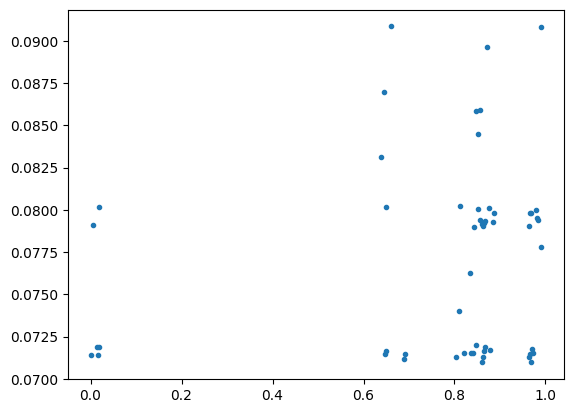

In [92]:
period=grouped_df2['diferencia'][0]
folded_time = abs_time % period/period
sorted = np.argsort(folded_time)

folded_time = folded_time[sorted]
folded_mag = magg[sorted]
#folded_error = error[sorted]

plt.errorbar(folded_time, folded_mag,fmt = '.')

# Clusters
El metodo a utilizar por ahora es K means por su facilidad de encontrar centroides que es como esperamos que la data se vea representada, si la data no es representada por esta modalidad tambien se plantea el uso de DBSCAN por si la densidad es mejor elemento. De forma paralela mientras se trabajaba en la limpieza de los datos se busco ver como los datos podian reaccionar a clusterizacion sin curva de luz. 

In [21]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn import datasets
import matplotlib.pyplot as plt

Para poder trabajar con esta parte en el github hay una base de datos que son los datos con menos de 8 elementos. El siguiente codigo no debe usarse.

In [ ]:
limpio_peque.to_csv('limpio_peque.csv')

In [ ]:
limpio_peque = pd.read_csv("Data\grouped_df1.csv")

In [22]:
sub_peque = limpio_peque.sample(frac=0.3)

In [32]:
sub_peque.head()

,oid,candid,fid,mjd,magpsf_corr,sigmapsf_corr,sigmapsf_corr_ext
76044432,ZTF18aakioui,941273102015015058,2,58695.273102,0.062371,5.096109e-07,5.115988e-07
55001958,ZTF18acqbjlf,1224456570715010084,1,58978.456574,0.072777,2.419767e-08,1.783544e-07
76464946,ZTF18acmhxec,988521483215010131,1,58742.521482,0.073051,4.259572e-07,5.157550e-07
90123182,ZTF19aacetxu,1131209371915015019,2,58885.209375,0.048193,1.182881e-03,5.920786e-08
12144556,ZTF19abndjmc,945420421515015021,1,58699.420428,0.065557,2.088038e-07,2.444983e-07


In [24]:
limpio_peque1=limpio_peque['magpsf_corr']
limpio_peque2=limpio_peque['sigmapsf_corr']
limpio_peque3=limpio_peque['sigmapsf_corr_ext']

In [33]:
df_unido=pd.concat([limpio_peque1, limpio_peque2, limpio_peque3], axis=1)

In [34]:
df_unido.head()

,magpsf_corr,sigmapsf_corr,sigmapsf_corr_ext
0,0.063876,1.182881e-03,1.348758e-07
8,0.081125,5.944622e-07,6.381659e-07
9,0.076267,5.048312e-07,5.390159e-07
11,0.033804,1.182881e-03,4.933861e-08
12,0.041588,1.182881e-03,5.151120e-08


Se usa el metodo del codo para comprobar la cantidad de clusters

C:\Users\julio\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\julio\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\julio\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\julio\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

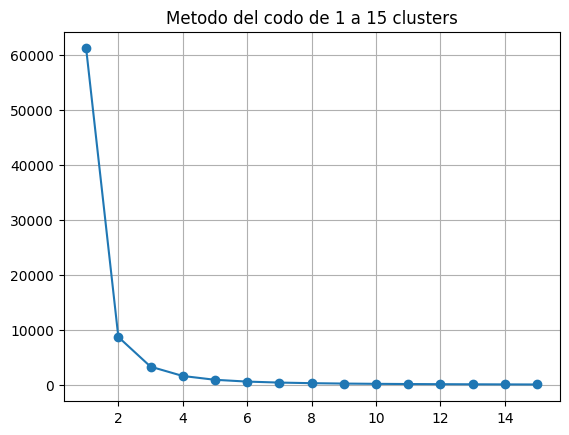

In [35]:
sse = []

clusters = list(range(1, 16))
for k in clusters:
    kmeans = KMeans(n_clusters=k).fit(df_unido)
    sse.append(kmeans.inertia_)

plt.plot(clusters, sse, marker="o")
plt.title("Metodo del codo de 1 a 15 clusters")
plt.grid(True)
plt.show()

Por conocimiento de filtros se uso 4, pero 3 tambien fue considerado por este metodo en otro set de pruebas

In [38]:
kmeans = KMeans(n_clusters=4, n_init=20, max_iter=300)
kmeans.fit(df_unido)
y_pred = kmeans.predict(df_unido)
kmeans.labels_

array([2, 2, 2, ..., 0, 0, 0])

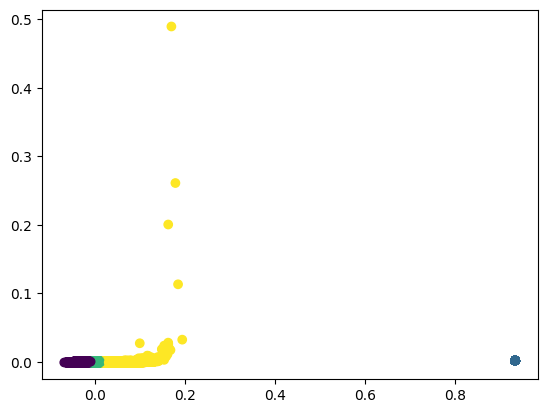

In [42]:
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples
new_X = PCA(n_components=2, random_state=0).fit_transform(df_unido)
plt.scatter(new_X[:, 0], new_X[:, 1],c=kmeans.labels_)
plt.show()

Luego se vio su capacidad predictiva

In [43]:
from sklearn.metrics import silhouette_score

In [46]:
kmeans1 = KMeans(n_clusters=3, n_init=20, max_iter=300)
kmeans1.fit(df_unido)
y_pred = kmeans.predict(df_unido)
kmeans1.labels_

array([0, 2, 2, ..., 0, 0, 0])

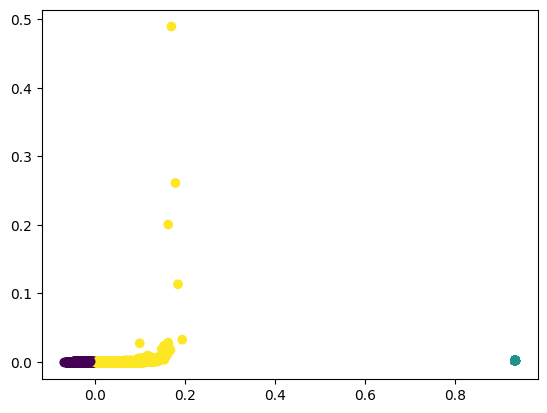

In [47]:
new_X = PCA(n_components=2, random_state=0).fit_transform(df_unido)
plt.scatter(new_X[:, 0], new_X[:, 1],c=kmeans1.labels_)
plt.show()

In [ ]:
print("Dataset X K-Means\t", silhouette_score(df_unido, kmeans1.labels_))